### Installation

`conda create -n ATACseq_SnapATAC python r-essentials jupyter pip pysam pybedtools -y`  
`pip install snaptools`  
`conda install -c bioconda bioconductor-rhdf5 bioconductor-rhdf5lib -y`  

### Preprocess

`SnapATAC_buenrostro2018_preprocess.ipynb`

###  Import packages

In [1]:
library(SnapATAC);
library(GenomicRanges);

Loading required package: Matrix
Loading required package: rhdf5
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:SnapATAC’:

    colMeans, colSums, rowMeans, rowSums

The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    le

In [2]:
packageVersion("SnapATAC")

[1] ‘1.0.0’

### Obtain Feature Matrix

`time ./run_snaptools.sh`

output: 59mins 56seconds

In [3]:
start_time <- Sys.time()

In [4]:
metadata <- read.table('./input/metadata.tsv',
                         header = TRUE,
                         stringsAsFactors=FALSE,quote="",row.names=1)

In [5]:
SnapATAC_metadata <- read.table('./SnapATAC_metadata.tsv',
                        header = TRUE,
                        stringsAsFactors=FALSE,quote="",row.names=1)

In [6]:
sum(SnapATAC_metadata$ID == rownames(metadata))

[1] 2034

#### Barcode selection (keep all the cells)

In [7]:
x.sp = createSnap(
file="Buenrostro2018.snap",
sample="Buenrostro2018",
do.par = TRUE,
num.cores=10)

Epoch: reading the barcode session ...


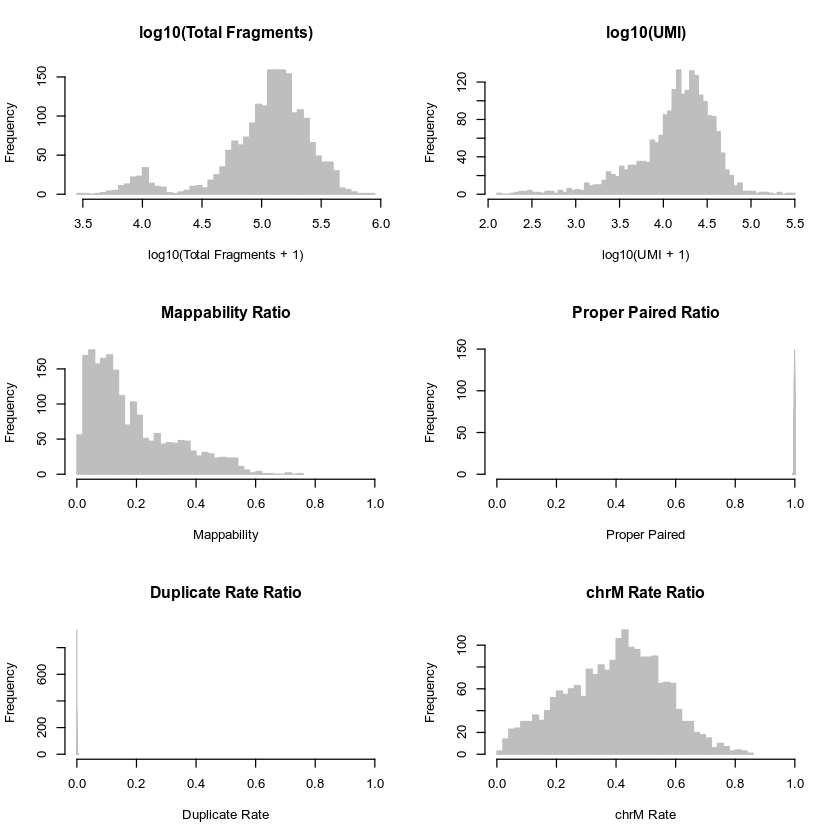

In [8]:
plotBarcode(
obj=x.sp, 
pdf.file.name=NULL, 
pdf.width=7, 
pdf.height=7, 
col="grey",
border="grey",
breaks=50
);

In [9]:
# # filter cells only using number of fragments and UMI with the following cutoffs
# x.sp = filterCells(
# obj=x.sp, 
# subset.names=c("fragment.num", "UMI"),
# low.thresholds=c(1000,1000),
# high.thresholds=c(Inf, Inf)
# );

#### Bin size selection (SnapATAC)

In [10]:
# show what bin sizes exist in atac_v1_adult_brain_fresh_5k.snap file
showBinSizes("Buenrostro2018.snap");
x.sp = addBmatToSnap(x.sp, bin.size=5000, num.cores=10);

[1] 5000

Epoch: reading cell-bin count matrix session ...


In [11]:
x.sp;

number of barcodes: 2034
number of bins: 627478
number of genes: 0
number of peaks: 0

In [12]:
summarySnap(x.sp);

Total  number of barcodes: 2034
Median number of sequencing fragments: 127155.5
Median number of uniquely mapped fragments: 16430.5
Median number of mappability ratio: 0.14
Median number of properly paired ratio: 1
Median number of duplicate ratio: 0
Median number of chrM ratio: 0.41
Median number of unique molecules (UMI): 16430.5


#### Fragments-in-promoter ratio (Keep all cells and skip this step)

#### Matrix binarization (SnapATAC)

In [13]:
x.sp = makeBinary(x.sp, mat="bmat");

####  Bin filtration (SnapATAC)

In [14]:
# system("wget http://mitra.stanford.edu/kundaje/akundaje/release/blacklists/hg19-human/wgEncodeHg19ConsensusSignalArtifactRegions.bed.gz")

##### Remove Blacklist Filter
The following cell contains the blacklist filtering step. They first read in the artifact regions from the wgEncode project. Then they define the black list as a genomic ranges object. idy1 finds overlaps in the feature matrix with the black list. idy2 finds overlaps between ChrM and the feature matrix. idy takes the union of idy1 and idy2. The final step subtracts everything in idy from the original x.sp matrix and defines a new x.sp matrix. 

In [15]:
# black_list = read.table('wgEncodeHg19ConsensusSignalArtifactRegions.bed.gz')
# black_list.gr = GRanges(black_list[,1], IRanges(black_list[,2], black_list[,3]));
# idy1 = queryHits(findOverlaps(x.sp@feature, black_list.gr));
idy2 = grep("chrM|random", x.sp@feature);
# idy = unique(c(idy1, idy2));
x.sp = x.sp[,-idy2, mat="bmat"];

In [16]:
x.sp

number of barcodes: 2034
number of bins: 626977
number of genes: 0
number of peaks: 0

In [17]:
# barcodes_no_bl - barcodes_bl
BL_filt = 626977 - 624297
BL_filt

[1] 2680

In [18]:
cat("The feature matrix in the original script run filtered out",as.numeric(BL_filt),"bins as belonging to artifacts within the blacklist.")

The feature matrix in the original script run filtered out 2680 bins as belonging to artifacts within the blacklist.

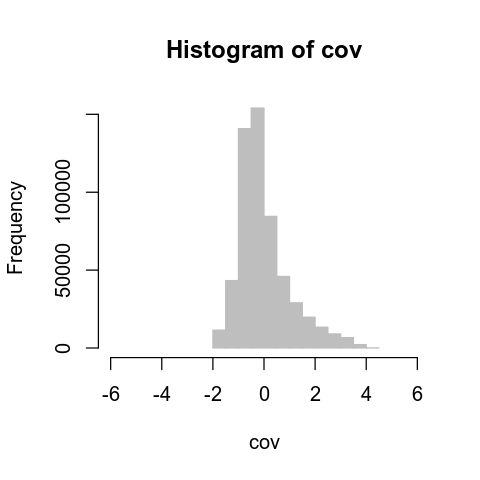

In [19]:
options(repr.plot.width=4, repr.plot.height=4)
plotBinCoverage(
    x.sp,
    pdf.file.name=NULL,
    col="grey",
    border="grey",
    breaks=10,
    xlim=c(-6,6)
    );

In [20]:
x.sp = filterBins(
x.sp,
low.threshold=-2,
high.threshold=2,
mat="bmat"
);
x.sp

number of barcodes: 2034
number of bins: 528901
number of genes: 0
number of peaks: 0

#### Jaccard matrix 

In [21]:
### the function failed when do.par=TRUE
x.sp = runJaccard(
obj = x.sp,
tmp.folder=tempdir(),
mat = "bmat",
max.var=2000,
ncell.chunk=1000,
do.par=FALSE,
num.cores=10,
seed.use=10
);

#### Normalization

In [22]:
### the function failed when do.par=TRUE
x.sp = runNormJaccard(
    obj = x.sp,
    tmp.folder=tempdir(),
    ncell.chunk=1000,
    method="normOVE",
    row.center=TRUE,
    row.scale=TRUE,
    low.threshold=-5,
    high.threshold=5,
    do.par=FALSE,
    num.cores=10,
    seed.use=10
    );

#### Linear Dimentionality Reduction

In [23]:
x.sp = runDimReduct(
    x.sp,
    pc.num=50,
    input.mat="jmat",
    method="svd",
    center=TRUE,
    scale=FALSE,
    seed.use=10
    );

#### Determine statistically significant principal components (SnapATAC)

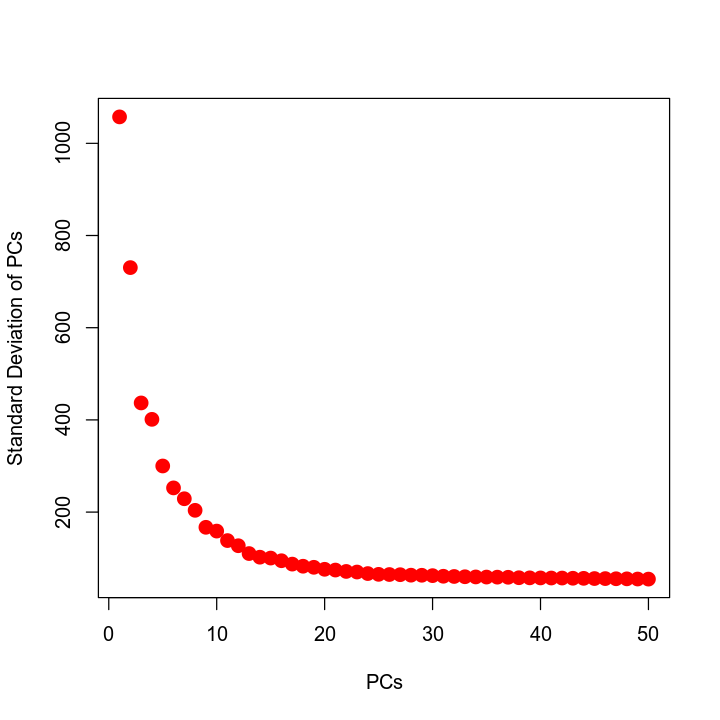

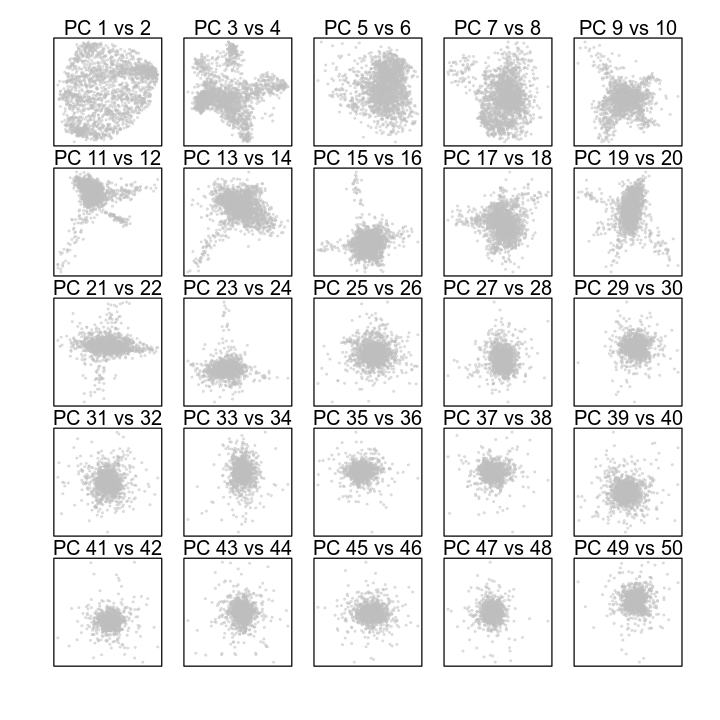

In [24]:
options(repr.plot.width=6, repr.plot.height=6)
plotDimReductElbow(
    obj=x.sp, 
    point.size=1.5,
    point.shape=19,
    point.color="red",
    point.alpha=1,
    pdf.file.name=NULL,
    pdf.height=7,
    pdf.width=7,
    labs.title="PCA Elbow plot",
    labs.subtitle=NULL
    );
plotDimReductPW(
    obj=x.sp, 
    pca.dims=1:50,
    point.size=0.3,
    point.color="grey",
    point.shape=19,
    point.alpha=0.6,
    down.sample=5000,
    pdf.file.name=NULL, 
    pdf.height=7, 
    pdf.width=7
    );

In [25]:
str(x.sp)

Formal class 'snap' [package "SnapATAC"] with 16 slots
  ..@ des     : chr(0) 
  ..@ barcode : chr [1:2034] "AAAAATCT" "AAAACCTC" "AAAACGTA" "AAAAGACC" ...
  ..@ file    : chr [1:2034] "/data/pinello/PROJECTS/2019_03_scATAC/Github_supp/Buenrostro_2018/test_blacklist/Buenrostro2018.snap" "/data/pinello/PROJECTS/2019_03_scATAC/Github_supp/Buenrostro_2018/test_blacklist/Buenrostro2018.snap" "/data/pinello/PROJECTS/2019_03_scATAC/Github_supp/Buenrostro_2018/test_blacklist/Buenrostro2018.snap" "/data/pinello/PROJECTS/2019_03_scATAC/Github_supp/Buenrostro_2018/test_blacklist/Buenrostro2018.snap" ...
  ..@ sample  : chr [1:2034] "Buenrostro2018" "Buenrostro2018" "Buenrostro2018" "Buenrostro2018" ...
  ..@ metaData:'data.frame':	2034 obs. of  6 variables:
  .. ..$ barcode: Factor w/ 2034 levels "AAAAATCT","AAAACCTC",..: 1 2 3 4 5 6 7 8 9 10 ...
  .. ..$ TN     : num [1:2034] 135497 197491 154610 112464 69803 ...
  .. ..$ UM     : num [1:2034] 15252 12022 7949 40605 24294 ...
  .. ..$ PP     : 

In [26]:
end_time <- Sys.time()
end_time - start_time

Time difference of 30.9224 secs

In [27]:
dim(x.sp@smat@dmat)

[1] 2034   50

In [28]:
df_out = data.frame(t(x.sp@smat@dmat)[1:20,],row.names = sprintf("PC_%s",seq(1:20)))
colnames(df_out) = SnapATAC_metadata[as.character(x.sp@metaData$barcode),]$ID

In [29]:
dim(df_out)
df_out[1:5,1:5]

[1]   20 2034

,singles-BM1214-GMP-160421-66,singles-BM0828-GMP-151027-33,BM1077-CMP-Frozen-160106-36,singles-BM0828-CMP-frozen-151118-87,singles-160818-BM1137-pDC-LS-78
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PC_1,0.020684887,0.01206255,0.027061578,0.035307775,0.006885282
PC_2,-0.025684352,-0.01498318,-0.006553185,0.011709267,-0.039651184
PC_3,-0.008710318,-0.02105197,0.009517309,0.004051875,0.011899027
PC_4,0.024722712,0.05234098,-0.012218828,0.003966942,0.048083445
PC_5,-0.030891841,-0.05366273,0.003050358,0.042363445,0.028622181


In [30]:
sum(colnames(df_out) == rownames(metadata))

[1] 0

In [31]:
df_out = df_out[rownames(metadata)]
dim(df_out)
df_out[1:5,1:5]

[1]   20 2034

,BM1077-CLP-Frozen-160106-13,BM1077-CLP-Frozen-160106-14,BM1077-CLP-Frozen-160106-2,BM1077-CLP-Frozen-160106-21,BM1077-CLP-Frozen-160106-27
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PC_1,0.006983931,0.0001183061,0.0004056221,0.005621594,0.015265006
PC_2,-0.012041244,-0.0121655404,-0.0113428167,-0.009504447,-0.007096972
PC_3,-0.018942210,-0.0148776648,-0.0200191482,-0.019540013,-0.010956394
PC_4,0.036480970,0.0349885452,0.0444467942,0.035149308,0.027656622
PC_5,-0.044525343,-0.0536511896,-0.0467667682,-0.055624883,-0.015751179


In [32]:
sum(colnames(df_out) == rownames(metadata))

[1] 2034

In [33]:
saveRDS(df_out, file = './output/feature_matrices/FM_SnapATAC_buenrostro2018_no_blacklist.rds')

### Downstream Analysis

#### KNN Graph Construction (SnapATAC)

In [34]:
x.sp = runKNN(
    obj=x.sp,
    pca.dims=1:30,
    weight.by.sd=FALSE,
    k=15
    );

#### Clustering (SnapATAC)

In [35]:
x.sp = runCluster(
    obj=x.sp,
    tmp.folder=tempdir(),
    louvain.lib="R-igraph",
    path.to.snaptools=NULL,
    seed.use=10
    );

#### Non-linear dimentionality reduction (SnapATAC)

In [36]:
x.sp = runViz(
    obj=x.sp, 
    tmp.folder=tempdir(),
    dims=2,
    pca.dims=1:30, 
    weight.by.sd=FALSE,
    method="Rtsne",
    fast_tsne_path=NULL,
    Y.init=NULL,
    seed.use=10,
    num.cores=5
    );

x.sp = runViz(
    obj=x.sp, 
    tmp.folder=tempdir(),
    dims=2,
    pca.dims=1:30, 
    weight.by.sd=FALSE,
    method="umap",
    fast_tsne_path=NULL,
    Y.init=NULL,
    seed.use=10,
    num.cores=5
    );

In [37]:
x.sp@sample = SnapATAC_metadata[as.character(x.sp@metaData$barcode),]$label

#### Visulization (SnapATAC)

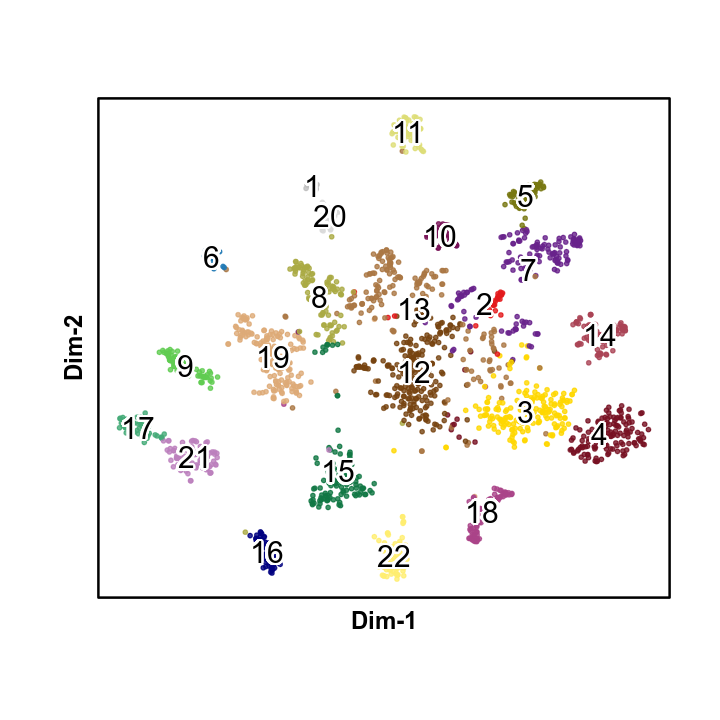

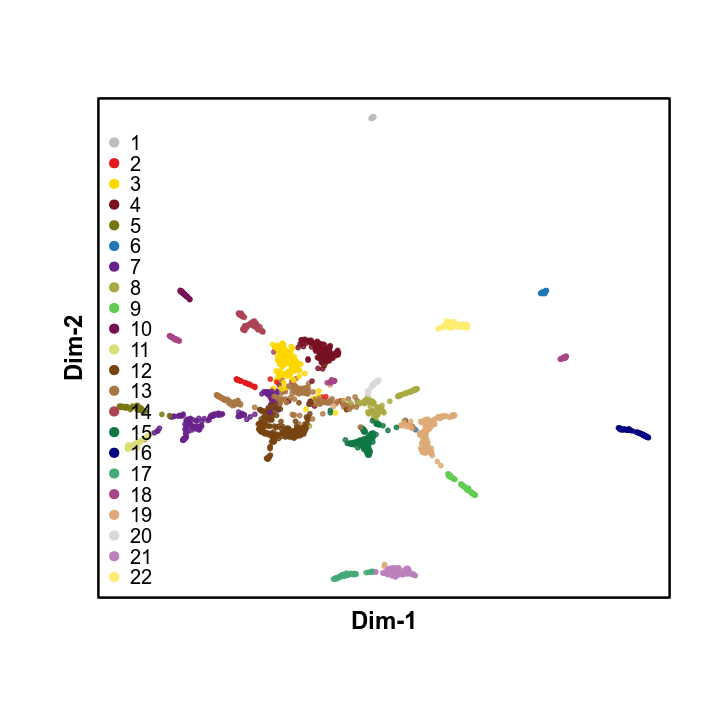

In [38]:
plotViz(
    obj=x.sp, 
    method="tsne", 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    point.color="cluster", 
    text.add=TRUE,
    text.size=1.5,
    text.color="black",
    text.halo.add=TRUE,
    text.halo.color="white",
    text.halo.width=0.2,
    down.sample=10000,
    pdf.file.name=NULL,
    pdf.width=7, 
    pdf.height=7
    );
plotViz(
    obj=x.sp, 
    method="umap", 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    point.color="cluster", 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=TRUE,
    text.halo.color="white",
    text.halo.width=0.2,
    down.sample=10000,
    legend.add=TRUE,
    pdf.file.name=NULL,
    pdf.width=7, 
    pdf.height=7
    );

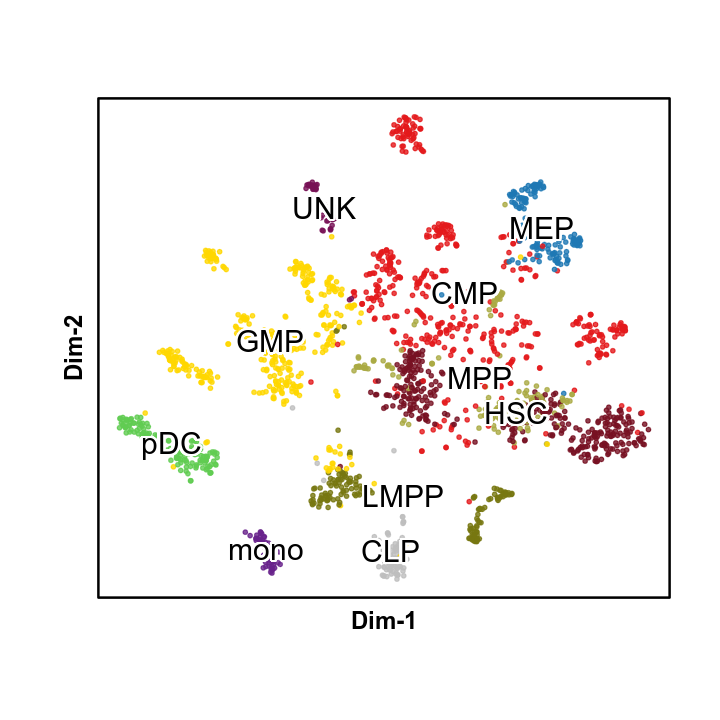

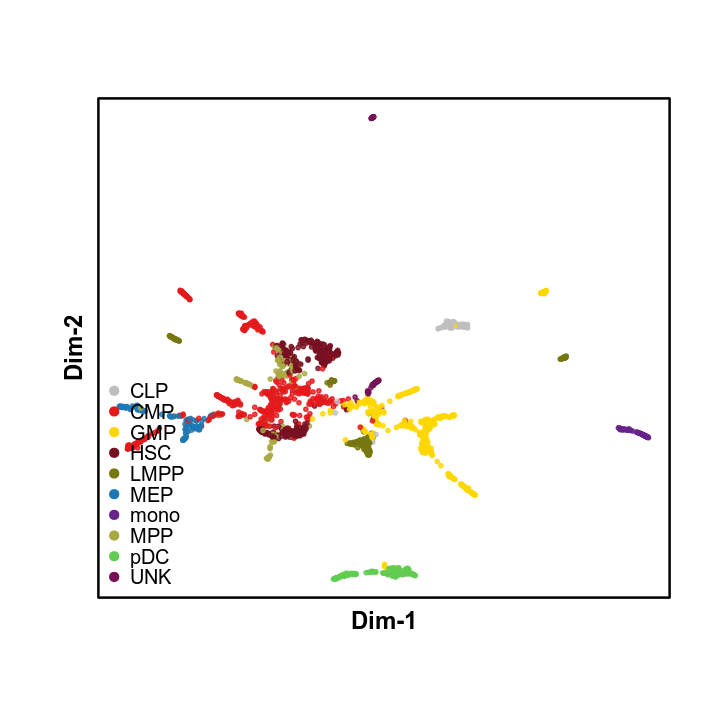

In [39]:
plotViz(
    obj=x.sp, 
    method="tsne", 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    point.color="sample", 
    text.add=TRUE,
    text.size=1.5,
    text.color="black",
    text.halo.add=TRUE,
    text.halo.color="white",
    text.halo.width=0.2,
    down.sample=10000,
    pdf.file.name=NULL,
    pdf.width=5, 
    pdf.height=5
    );
plotViz(
    obj=x.sp, 
    method="umap", 
    point.size=0.5, 
    point.shape=19, 
    point.alpha=0.8, 
    point.color="sample", 
    text.add=FALSE,
    text.size=1.5,
    text.color="black",
    text.halo.add=TRUE,
    text.halo.color="white",
    text.halo.width=0.2,
    down.sample=10000,
    legend.add=TRUE,
    pdf.file.name=NULL,
    pdf.width=5, 
    pdf.height=5
    );

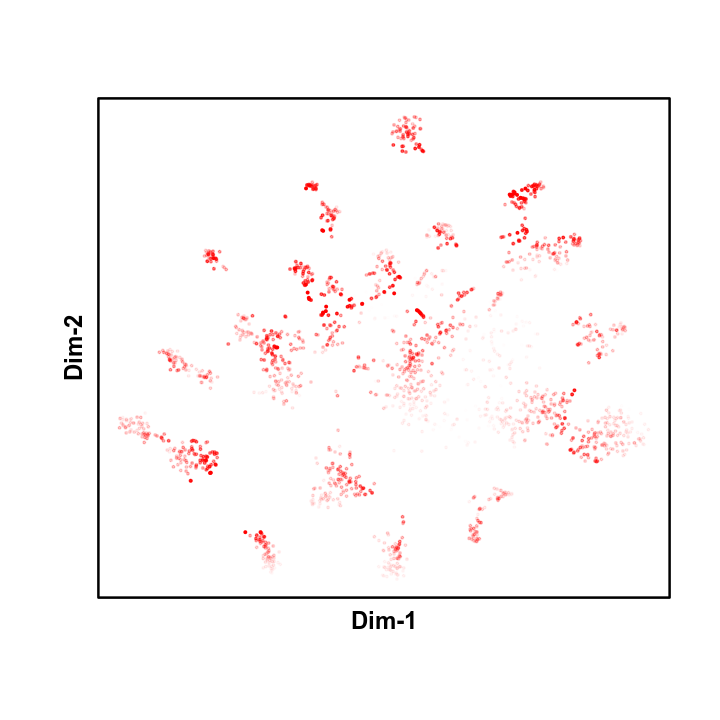

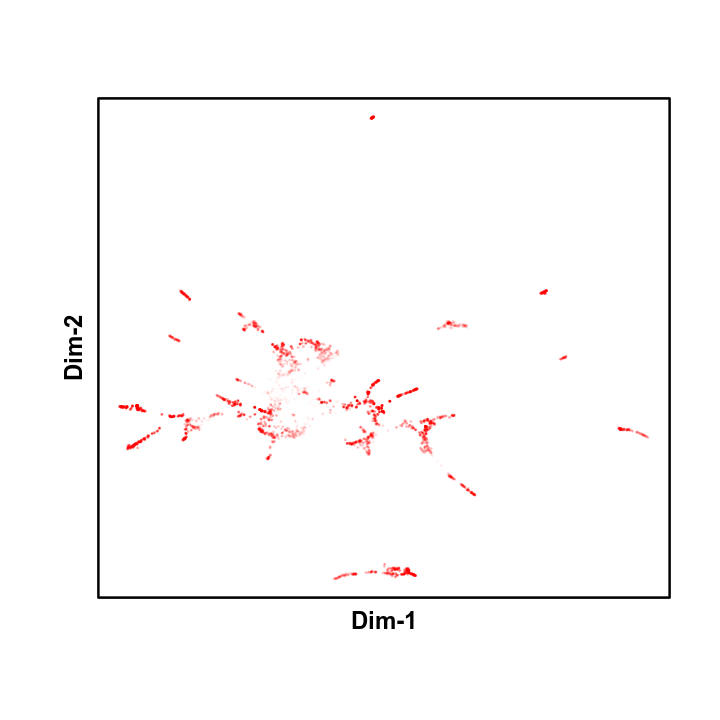

In [40]:
feature.value = SnapATAC::rowSums(x.sp@bmat);
feature.value = pmin(feature.value, quantile(feature.value, 0.99));
feature.value = pmax(feature.value, 0);
feature.value = (feature.value-min(feature.value))/(max(feature.value)-min(feature.value));
PlotFeatureSingle(
    obj=x.sp, 
    feature.value=feature.value,
    method="tsne", 
    point.size=0.3, 
    point.shape=19, 
    point.color="red", 
    down.sample=10000, 
    pdf.file.name=NULL, 
    pdf.width=7, 
    pdf.height==7
    );
PlotFeatureSingle(
    obj=x.sp, 
    feature.value=feature.value,
    method="umap", 
    point.size=0.2, 
    point.shape=19, 
    point.color="red", 
    down.sample=10000, 
    pdf.file.name=NULL, 
    pdf.width=7, 
    pdf.height==7
    );

In [41]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS: /data/pinello/SHARED_SOFTWARE/anaconda3/envs/ATACseq_SnapATAC_py37/lib/R/lib/libRblas.so
LAPACK: /data/pinello/SHARED_SOFTWARE/anaconda3/envs/ATACseq_SnapATAC_py37/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
[1] GenomicRanges_1.34.0 GenomeInfoDb_1.18.2  IRanges_2.16.0      
[4] S4Vectors_0.20.1     BiocGenerics_0.28.0  SnapATAC_1.0.0      
[7] rhdf5_2.26.2     

In [42]:
save.image(file = 'SnapATAC_buenrostro2018.RData')